In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt
from math import log10
%matplotlib inline

In [27]:
import torch 
from torch.nn import init
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
import torch.utils.data as data

In [28]:
root = '/workspace/nagaraj/BSDS300/images/'

In [29]:
os.getcwd()

'/workspace/nagaraj'

In [30]:
class DataSuperRes(data.Dataset):
    def __init__(self, path, input_transform = None, target_transform = None):
        super(DataSuperRes, self).__init__()
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.filepath = [os.path.join(path,x) for x in os.listdir(path)]
        
    def __len__(self):
        return len(self.filepath)
    
    def __getitem__(self,index):
        image = Image.open(self.filepath[index]).convert('YCbCr')
        image_rgb = image.convert('RGB')
        y, _ , _ = image.split()
        target = y.copy()
        if self.input_transform:
            img = self.input_transform(y)
        if self.target_transform:
            target = self.target_transform(target)
            image_rgb = self.target_transform(image_rgb)
        #tensor = transforms.ToTensor()
        #image = tensor(image)
        return image_rgb, img, target
    

In [31]:
upscale_factor = 3
batch_size = 4
epochs = 700
lr = 0.001

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
def Valid_crop_size(crop_size, upscalefactor):
    return crop_size - (crop_size % upscalefactor)

In [34]:
# We resize the image to size/upscale_factor to match the output of the model
crop_size = Valid_crop_size(256,upscale_factor)
input_transforms = transforms.Compose([transforms.CenterCrop(crop_size),
                                      transforms.Resize(crop_size//upscale_factor),
                                      transforms.ToTensor()
                                      ])

target_transforms = transforms.Compose([transforms.CenterCrop(crop_size),
                                      transforms.ToTensor()
                                      ])


In [35]:
train_set = DataSuperRes(root + 'train', input_transform=input_transforms, target_transform= target_transforms)
test_set = DataSuperRes(root + 'test', input_transform=input_transforms, target_transform=target_transforms)

trainloader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [36]:
#print(len(trainloader))

In [37]:
#len(os.listdir(root + 'train'))/8

In [38]:
#w = torch.empty(2,3)
#torch.nn.init.orthogonal_(w,gain=1)

In [39]:
#torch.nn.init.orthogonal_(w,gain=1)

In [40]:
def show_img(epoch, normal, super_resolution):
    
    tensor = transforms.ToTensor()
    PIL = transforms.ToPILImage()
    img_normal = PIL(normal)
    
    img_ycbcr = img_normal.convert('YCbCr')
    _, img_cb, img_cr = img_ycbcr.split()
    
    #super_resolution = np.transpose(super_resolution, (1,2,0))
    normal = np.transpose(normal, (1,2,0))
    
    out_img_y = super_resolution*255.0
    out_img_y = out_img_y.clip(0, 255)
    #print(out_img_y.shape)
    #out_img_y = out_img_y.squeeze()
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
    print(out_img_y.size)
    
    out_img_cb = img_cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = img_cr.resize(out_img_y.size, Image.BICUBIC)
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr])
    out_img = out_img.convert('RGB')
    #out_img = Image.merge('RGB', [out_img_y, out_img_cb, out_img_cr])
    print(out_img.size)
    
    if epoch % 150 == 0:
        out_img.save(root+'out.png')
    fig=plt.figure(figsize=[10,5])
    
    fig.add_subplot(1, 2, 1, title='Original Image')
    plt.imshow(normal)
    
    fig.add_subplot(1, 2, 2, title='Super resolution Image')
    plt.imshow(out_img)
    '''
    fig.add_subplot(2, 3, 3, title='y component')
    plt.imshow(out_img_y)
    
    fig.add_subplot(2, 3, 4, title='cb')
    plt.imshow(out_img_cb)
    
    fig.add_subplot(2, 3, 5, title='cr')
    plt.imshow(out_img_cr)
    
    fig.add_subplot(2, 3, 6, title='ycbcr from rgb')
    plt.imshow(img_normal)'''
    
    fig.subplots_adjust(wspace = 0.5)
    plt.show()
    

In [41]:
class Network(nn.Module):
    def __init__(self, upscale_factor):
        super(Network, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x
    
    # A way to initialize weights. Read more here: https://pytorch.org/docs/stable/_modules/torch/nn/init.html#orthogonal_
    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

In [42]:
model = Network(upscale_factor=upscale_factor).to(device)

In [43]:
model

Network(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

In [44]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

Starting epoch: 1/700
Training loss at epoch 0: 0.025355070317164063
Test loss at epoch 0: 0.02014187216758728
Average PSNR: 40.33660121371368
Starting epoch: 2/700
Training loss at epoch 1: 0.005809731031768024
Test loss at epoch 1: 0.011578626101836562
Average PSNR: 45.04083385824797
Starting epoch: 3/700
Training loss at epoch 2: 0.004624189422465861
Test loss at epoch 2: 0.009712007343769074
Average PSNR: 46.592953465509645
Starting epoch: 4/700
Training loss at epoch 3: 0.0041451777424663305
Test loss at epoch 3: 0.009098386811092495
Average PSNR: 47.15942520828492
Starting epoch: 5/700
Training loss at epoch 4: 0.0038308755494654177
Test loss at epoch 4: 0.008264582380652427
Average PSNR: 48.03444789561984
Starting epoch: 6/700
Training loss at epoch 5: 0.003626359256450087
Test loss at epoch 5: 0.007941336827352643
Average PSNR: 48.39268349145783
Starting epoch: 7/700
Training loss at epoch 6: 0.0035508487815968694
Test loss at epoch 6: 0.0077586750965565445
Average PSNR: 48.602

Training loss at epoch 56: 0.0030801489669829607
Test loss at epoch 56: 0.006852677837014198
Average PSNR: 49.73146652456925
Starting epoch: 58/700
Training loss at epoch 57: 0.0030857963976450263
Test loss at epoch 57: 0.00685214826837182
Average PSNR: 49.73218217232474
Starting epoch: 59/700
Training loss at epoch 58: 0.0030832286993972956
Test loss at epoch 58: 0.006846316615119577
Average PSNR: 49.740456045640705
Starting epoch: 60/700
Training loss at epoch 59: 0.003097171375993639
Test loss at epoch 59: 0.006900685308501124
Average PSNR: 49.666215264207125
Starting epoch: 61/700
Training loss at epoch 60: 0.003076928029768169
Test loss at epoch 60: 0.006846974287182093
Average PSNR: 49.73965567010898
Starting epoch: 62/700
Training loss at epoch 61: 0.0030632699257694186
Test loss at epoch 61: 0.006826842073351145
Average PSNR: 49.766997640862066
Starting epoch: 63/700
Training loss at epoch 62: 0.003090703359339386
Test loss at epoch 62: 0.006879841964691877
Average PSNR: 49.694

Training loss at epoch 112: 0.002985116376075894
Test loss at epoch 112: 0.006686736419796943
Average PSNR: 49.95954364525717
Starting epoch: 114/700
Training loss at epoch 113: 0.00305939732119441
Test loss at epoch 113: 0.006843073358759284
Average PSNR: 49.74360720770982
Starting epoch: 115/700
Training loss at epoch 114: 0.0029813172901049256
Test loss at epoch 114: 0.006695029023103416
Average PSNR: 49.947758756107866
Starting epoch: 116/700
Training loss at epoch 115: 0.0029910874483175575
Test loss at epoch 115: 0.006736125992611051
Average PSNR: 49.89264133629531
Starting epoch: 117/700
Training loss at epoch 116: 0.003246251787059009
Test loss at epoch 116: 0.007928560469299555
Average PSNR: 48.465984100164434
Starting epoch: 118/700
Training loss at epoch 117: 0.0031497826520353557
Test loss at epoch 117: 0.006903294986113906
Average PSNR: 49.658274286879966
Starting epoch: 119/700
Training loss at epoch 118: 0.0029854971857275815
Test loss at epoch 118: 0.006698350850492716


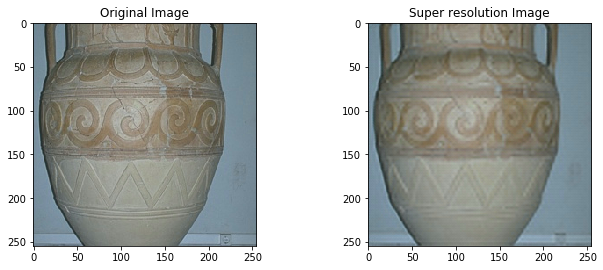

(255, 255)
(255, 255)


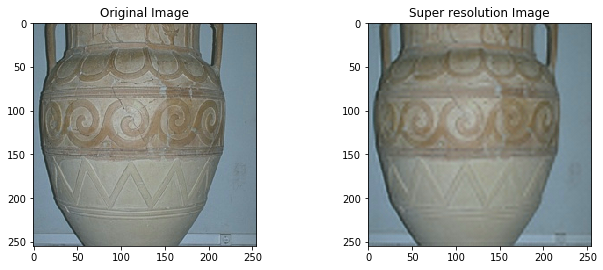

Training loss at epoch 149: 0.0029251265572384
Test loss at epoch 149: 0.006610813001170755
Average PSNR: 50.06895104670708
Starting epoch: 151/700
Training loss at epoch 150: 0.0029285025701392443
Test loss at epoch 150: 0.006610672315582633
Average PSNR: 50.0700113898767
Starting epoch: 152/700
Training loss at epoch 151: 0.0029333807807415723
Test loss at epoch 151: 0.006640470763668418
Average PSNR: 50.02620409519406
Starting epoch: 153/700
Training loss at epoch 152: 0.0030298470228444785
Test loss at epoch 152: 0.006798803890123963
Average PSNR: 49.806027392113016
Starting epoch: 154/700
Training loss at epoch 153: 0.003136624440085143
Test loss at epoch 153: 0.00675108483992517
Average PSNR: 49.87112641024227
Starting epoch: 155/700
Training loss at epoch 154: 0.0029249009513296186
Test loss at epoch 154: 0.006590393437072635
Average PSNR: 50.097580018610316
Starting epoch: 156/700
Training loss at epoch 155: 0.0029142423113808036
Test loss at epoch 155: 0.006603596271015704
Ave

Training loss at epoch 204: 0.00287465296452865
Test loss at epoch 204: 0.006544963633641601
Average PSNR: 50.16352989311878
Starting epoch: 206/700
Training loss at epoch 205: 0.002877686319407076
Test loss at epoch 205: 0.006557697081007063
Average PSNR: 50.14479928117496
Starting epoch: 207/700
Training loss at epoch 206: 0.002873262157663703
Test loss at epoch 206: 0.006567854946479201
Average PSNR: 50.1310988863437
Starting epoch: 208/700
Training loss at epoch 207: 0.0028699969360604883
Test loss at epoch 207: 0.006560137690976262
Average PSNR: 50.13994775239188
Starting epoch: 209/700
Training loss at epoch 208: 0.0028699512232560663
Test loss at epoch 208: 0.006553251389414072
Average PSNR: 50.15042553036814
Starting epoch: 210/700
Training loss at epoch 209: 0.002871516803279519
Test loss at epoch 209: 0.0065619273809716105
Average PSNR: 50.138914181247046
Starting epoch: 211/700
Training loss at epoch 210: 0.002873548970092088
Test loss at epoch 210: 0.006571167372167111
Aver

Training loss at epoch 259: 0.0029025689978152513
Test loss at epoch 259: 0.006889635580591857
Average PSNR: 49.68464653842527
Starting epoch: 261/700
Training loss at epoch 260: 0.002877452726243064
Test loss at epoch 260: 0.006585494866594672
Average PSNR: 50.10582381657875
Starting epoch: 262/700
Training loss at epoch 261: 0.0028725005057640375
Test loss at epoch 261: 0.006612711125053465
Average PSNR: 50.06805113730412
Starting epoch: 263/700
Training loss at epoch 262: 0.002828781015705317
Test loss at epoch 262: 0.0065349724935367705
Average PSNR: 50.178950479121134
Starting epoch: 264/700
Training loss at epoch 263: 0.0028264397522434594
Test loss at epoch 263: 0.0065472041210159655
Average PSNR: 50.16232240412648
Starting epoch: 265/700
Training loss at epoch 264: 0.0028247709036804737
Test loss at epoch 264: 0.006537103247828782
Average PSNR: 50.17612384520482
Starting epoch: 266/700
Training loss at epoch 265: 0.002825444664340466
Test loss at epoch 265: 0.006539947944693267

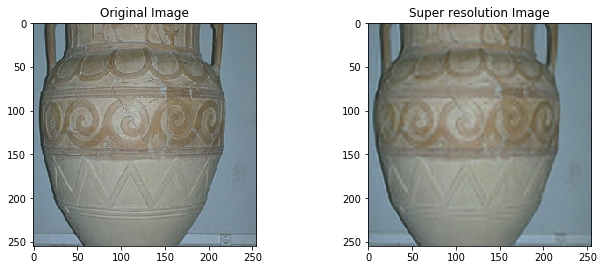

(255, 255)
(255, 255)


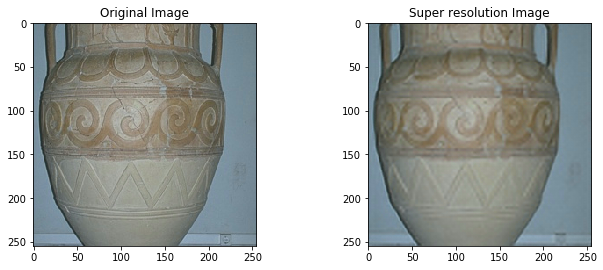

Training loss at epoch 299: 0.0028043431835249066
Test loss at epoch 299: 0.0065726799285039305
Average PSNR: 50.12544867117785
Starting epoch: 301/700
Training loss at epoch 300: 0.002908456418663263
Test loss at epoch 300: 0.006791980974376202
Average PSNR: 49.816340076262094
Starting epoch: 302/700
Training loss at epoch 301: 0.00283909100224264
Test loss at epoch 301: 0.006549817733466625
Average PSNR: 50.15765552483361
Starting epoch: 303/700
Training loss at epoch 302: 0.0027936478378251194
Test loss at epoch 302: 0.006545418198220432
Average PSNR: 50.16586376017151
Starting epoch: 304/700
Training loss at epoch 303: 0.0027921432710718364
Test loss at epoch 303: 0.006551433028653264
Average PSNR: 50.158386709581215
Starting epoch: 305/700
Training loss at epoch 304: 0.0027920083585195243
Test loss at epoch 304: 0.00654759123455733
Average PSNR: 50.16130275204887
Starting epoch: 306/700
Training loss at epoch 305: 0.002789910584688187
Test loss at epoch 305: 0.006558898496441543
A

Training loss at epoch 354: 0.0027721347962506113
Test loss at epoch 354: 0.006617345628328621
Average PSNR: 50.06516908092823
Starting epoch: 356/700
Training loss at epoch 355: 0.0027945132227614523
Test loss at epoch 355: 0.006577181117609143
Average PSNR: 50.1224091805764
Starting epoch: 357/700
Training loss at epoch 356: 0.002772060218267143
Test loss at epoch 356: 0.006634098188951612
Average PSNR: 50.042187647775044
Starting epoch: 358/700
Training loss at epoch 357: 0.0027863152022473514
Test loss at epoch 357: 0.006568715902976692
Average PSNR: 50.13414099557836
Starting epoch: 359/700
Training loss at epoch 358: 0.0027794304443523286
Test loss at epoch 358: 0.00657517624553293
Average PSNR: 50.12569876903032
Starting epoch: 360/700
Training loss at epoch 359: 0.0027733024407643825
Test loss at epoch 359: 0.006564467009156943
Average PSNR: 50.141355320185205
Starting epoch: 361/700
Training loss at epoch 360: 0.002764361035078764
Test loss at epoch 360: 0.006571491449140012
A

Training loss at epoch 408: 0.00273939439561218
Test loss at epoch 408: 0.0066308230441063645
Average PSNR: 50.04860024979999
Starting epoch: 410/700
Training loss at epoch 409: 0.0027323712839279323
Test loss at epoch 409: 0.006558634848333895
Average PSNR: 50.153584283320086
Starting epoch: 411/700
Training loss at epoch 410: 0.0027268671162892135
Test loss at epoch 410: 0.006575719201937318
Average PSNR: 50.12837848107275
Starting epoch: 412/700
Training loss at epoch 411: 0.0027253577508963645
Test loss at epoch 411: 0.006588109279982745
Average PSNR: 50.11120154931909
Starting epoch: 413/700
Training loss at epoch 412: 0.0027278816839680074
Test loss at epoch 412: 0.0065920617524534465
Average PSNR: 50.10618272809584
Starting epoch: 414/700
Training loss at epoch 413: 0.0027379665081389247
Test loss at epoch 413: 0.006582988817244768
Average PSNR: 50.11604032233523
Starting epoch: 415/700
Training loss at epoch 414: 0.002734124418348074
Test loss at epoch 414: 0.00657309188041836


In [ ]:
train_losses = []
test_losses = []
print_every = 25
steps = 1
for e in range(epochs):
    batch_loss = 0
    test_loss = 0
    avg_psnr = 0
    print(f'Starting epoch: {e+1}/{epochs}')
    for color, images, target in trainloader:
        images, target = images.to(device), target.to(device)
        #print('train images input shape:',images.shape)
        
        output = model(images)
        #print('train model output shape:',output.shape)
        loss = criterion(output,target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        steps = steps + 1
        batch_loss += loss.item()
        
        if steps % print_every == 0:
            with torch.no_grad():
                model.eval()
                for color_test, images_test, target_test in testloader:
                    images_test, target_test = images_test.to(device), target_test.to(device)
                    #print('test images input shape:',images_test.shape)
                    output_test = model(images_test)
                    #print('test model output shape:',output_test.shape)
                    loss = criterion(output_test,target_test)
                    test_loss +=loss.item()

                    psnr = 10 * log10(1 / loss.item())
                    avg_psnr += psnr

            #print(output.shape)
            #print(target.shape)
            #print(type(color))
            image_out = output_test[0].cpu().numpy()
            #target_out = target_test[0].cpu().numpy()
            color = color_test[0]
            if (e+1)%150 == 0:
                show_img(e, color, image_out)
            
    if(e+1)%200 == 0:
        model_out_path = "model_epoch_{}.pth".format(e)
        torch.save(model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))
    train_losses.append(batch_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    print(f"Training loss at epoch {e}: {batch_loss/len(trainloader)}")
    print(f"Test loss at epoch {e}: {test_loss/len(testloader)}")
    print(f"Average PSNR: {avg_psnr/len(testloader)}")
    model.train()